<h1>Controlling a Catheter <br>for Cardiac Ablation</h1>
<p>Daniel Newman <br>
<a href="mailto:danielnewman09@gmail.com">danielnewman09@gmail.com</a> <br>
<a href="http://danielnewman09.github.io">http://danielnewman09.github.io</a> <br>

The control objective for this initial study is to hold the catheter endpoint steady at a specified point in $\bar{X}$. Due the the external disturbance induced by blood flow, a model predictive control (MPC) approach will be used to maintain accurate positioning. The general formulation for MPC of a linear system is realized by discretizing the system:

\begin{align}
x_{k+1} &= A x_k + B u_k + \Omega \Gamma_k \\
\label{eq:discrete_ss}
\end{align}

and determining the correct input, $u_k$ which minimizes a quadratic cost function:

\begin{equation}
\label{eq:costfunction}
J = \sum_{i=k}^{k+N} Q (y_d - y_i)^2 + R (u_i - u_{i-1})^2,
\end{equation}

where $N$ is the prediction horizon. In this cost function, the predicted error in the outputs, $y_i$, are evaluated relative to desired values, $y_d$. These values are weighted by the state weights, $Q$. Similarly, the change in controller effort from the previous value is penalized and scaled by the input weight, $R$. The input cost is formulated in this way because the actuator effort is not expected to go to zero in the presence of disturbances and desired displacements. Rather, to follow a smooth trajectory, the change in input from one time increment to another should be minimal. 

The output of the catheter model which should be controlled is the position of its tip. Using the model presented in this work, the position is given by:

\begin{equation}
\label{eq:y-output}
y = \sum_{i=0}^{n} l_i \sin{\theta_i},
\end{equation}

and the derivative of the position is:

\begin{equation}
\label{eq:y-dot-output}
\dot{y} = \sum_{i=0}^n l_i \dot{\theta}_i \cos{\theta_i}. 
\end{equation}

It is further assumed that the exogeneous input from the hemodynamic forces can be accurately predicted and incorporated into the MPC framework. Therefore, \eqref{eq:discrete_ss} is used as a constraint for the controller. In addition, the actuator effort is limited below the maximum available level. In total, the optimization problem for the model predictive controller takes the form:

\begin{align}
\label{eq:posconstraints}
& \underset{t}{\text{minimize}}
& &  \sum_{i=k}^{k+N} Q (y_d - y_i)^2 + R (u_i - u_{i-1})^2\\
& \text{subject to}
& & x_{k+1} = A x_k + B u_k + \Omega \Gamma_k,\\
&&&  u_k \leq u_{max}.\\
\end{align}


In [5]:
from mypackage.catheter_utils import *

# Numpy library to perform computational heavy lifting
import numpy as np

# Crawlab plotting toolbox to generate nice plots
import crawlab_toolbox.plotting as plot

from matplotlib.animation import writers
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib as mpl

# Convex optimization package for Model Predictive Control
import cvxpy as cvx

# Python clone of the Matlab Control Systems Toolbox
import control

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Number of elements
n = 5

# Total mass 
M = 1 # kg

# Total length
L = 1 # m

# Young's Modulus
E = 10e-3

# Moment of inertia
I = 1

p = [M, L, E, I]

In [7]:
kane = derive_sys(n,p)
funcs = parameterize(n,kane)

KM, fr, fr_star, q, u, Torque, F_in, lengths, masses = kane
A,B = linearize_system(n,kane)

In [92]:
def get_mpc_response(n,A,B,args,mpc_args):
    force_max, time, X0, y_desired, lengths = args
    
    dt = time[1] - time[0]
    
    Q_y, Q_yd, R, prediction_dt, prediction_horizon = mpc_args
    B_input = np.atleast_2d(B[:,0]).T
    B_disturbance = np.atleast_2d(B[:,1:])

    prediction_time = np.arange(0,tmax + prediction_dt,prediction_dt)

    num_samples = tmax / prediction_dt # Determine the number of samples in the sim time

    C = np.eye(2*n)
    D = np.zeros((2*n,1))
    
    
    sys_disturb = control.ss(A, B_disturbance, C, np.zeros((2*n,B_disturbance.shape[1])))
    sys = control.ss(A, B_input, C, np.zeros((2*n,B_input.shape[1])))

    # Get the number of states and inputs - for use in setting up the optimization
    # problem
    num_states = np.shape(A)[0] # Number of states
    num_inputs = np.shape(B_input)[1] # Number of inputs
    
    # Convert the system to digital. We need to use the discrete version of the 
    # system for the MPC solution
    digital_sys = control.sample_system(sys, prediction_dt)
    digital_sys_disturb = control.sample_system(sys_disturb, prediction_dt)

    # Convert the system to digital. We need to use the discrete version of the 
    # system for the MPC solution
    digital_sys = control.sample_system(sys, prediction_dt)    

    q_i = np.array(X0[:n])
    u_i = np.array(X0[n:])

    # initial positions and velocities – assumed to be given in degrees
    x0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])
    u0 = np.array([0.])
    
    tau = np.zeros(n)
    
    x_total = np.array([x0]).T  
    u_total = np.zeros(1,)
    tip_y_total = np.zeros(1,)
    tip_x_total = np.zeros(1,)
    cost_total = np.zeros(1,)
    
    # Form the variables needed for the cvxpy solver
    x = cvx.Variable(int(num_states), int(prediction_horizon)+1)
    u = cvx.Variable(int(num_inputs), int(prediction_horizon))

    trig_tol = 0.0001
    
    # Now, we work through the range of the simulation time. At each step, we
    # look prediction_horizon samples into the future and optimize the input over
    # that range of time. We then take only the first element of that sequence
    # as the current input, then repeat.
    for i in range(int(num_samples)):

        states = []
        for t in range(prediction_horizon):
            tau = get_forces(n,x0,lengths,prediction_time[i])
            
            u_increment = u[:,t] - u_total[-1]
            
            cost =  (Q_y * cvx.sum_squares(y_desired - sum(lengths * (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) + (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) * (x[:n,t] - np.floor(x0[:n] / trig_tol) * trig_tol))))) +
                     Q_yd * cvx.sum_squares(0. - sum(lengths * x[n:,t+1] * np.cos(np.floor(x0[:n] / trig_tol) * trig_tol))) + 
                    R * cvx.sum_squares(u_increment))
            
            constr = [x[:,t+1] == digital_sys.A * x[:, t] + digital_sys.B * u[:, t] + np.matmul(digital_sys_disturb.B,tau[1:]).T,
                      cvx.norm(u[:,t], 'inf') <= force_max]
            states.append(cvx.Problem(cvx.Minimize(cost), constr))

        states.append(cvx.Problem(cvx.Minimize(cost), constr))
        
        # sums problem objectives and concatenates constraints.
        prob = sum(states)
        prob.constraints += [x[:,0] == x0]
        prob.solve(solver=cvx.ECOS)
        
        u_total = np.append(u_total, u[0].value)
        x_total = np.append(x_total,np.array(x[:,1].value),axis=1)
        
        current_cost = Q_y * np.square(y_desired - np.sum((lengths * (np.sin(np.floor(x0[:n] / trig_tol) * trig_tol) + (np.cos(np.floor(x0[:n] / trig_tol) * trig_tol) * (np.array(x[:n,1].value).flatten() - np.floor(x0[:n] / trig_tol) * trig_tol))))))
                    
        # Finally, save the current state as the initial condition for the next
        x0 = np.array(x[:,1].value.A.flatten())
        
        curr_x,curr_y = get_xy_coords(n,x0,lengths)
        
        tip_x_total = np.append(tip_x_total,curr_x[:-1])
        tip_y_total = np.append(tip_y_total,curr_y[:,-1])
        
        cost_total = np.append(cost_total,current_cost)
    
    sampling_multiple = prediction_dt / dt

    sampling_offset = np.ones(int(sampling_multiple),)

    u_newDt = np.repeat(u_total, sampling_multiple)
    u_newDt = u_newDt[int(sampling_multiple):]
    
    x_total_new = np.repeat(x_total, sampling_multiple,axis=1).T
    x_total_new =x_total_new[int(sampling_multiple):,:]
    
    cost_total_new = np.repeat(cost_total,sampling_multiple)
    cost_total_new = cost_total_new[int(sampling_multiple):]
    
    u = np.zeros(B.shape[1])
    
    x0 = np.concatenate([np.tile(q_i,n),np.tile(u_i,n)])

    # Convert the system to digital using the faster sampling rate.
    #new_digital_sys = control.sample_system(sys, dt)

    # Now, simulate the systema at the new higher sampling rate
    #t_out, y_out, x_out = control.forced_response(new_digital_sys, TIME, u_newDt)
    
    # function which computes the derivatives of parameters
    def gradient(x, currtime, t_sys, f_in):
        u = np.zeros(B.shape[1])
        u[0] = np.interp(currtime,t_sys,f_in)
        tau = get_forces(n,x,lengths,currtime)
        
        u[1:] += tau[1:]
       
        sol = np.matmul(A,x) + np.matmul(B,u)

        return np.array(sol)
    
    #return y_out,u_ewDt
    return odeint(gradient, x0, time, args=(time,u_newDt,)),u_newDt,x_total_new,cost_total_new

In [111]:
# Initial positions and velocities
theta0_z = 0.
theta0dot_z = 0.
X0 = np.array([theta0_z,theta0dot_z])

# Maximum allowable actuator effort
force_max = 1

# Time information
dt = 0.01
tmax = 10.
time = np.arange(0,tmax,dt)

# Desired y-coordinate of the tip
y_desired = 0.5

# Control parameters
kp = 10.
kd = 5.
use_control = True

q_y = 1000
q_yd = 1.
r = 1.
prediction_dt = 0.01
prediction_samples = 10

mpc_args = [q_y,q_yd,r,prediction_dt,prediction_samples]

args = [force_max, time, X0, y_desired, lengths]
control_args = [kp,kd,use_control]

In [112]:
mpc_response,mpc_input,predicted_states,predicted_cost = get_mpc_response(n,A,B,args,mpc_args)

In [113]:
lin_response = linear_response(n,A,B,args,control_args)

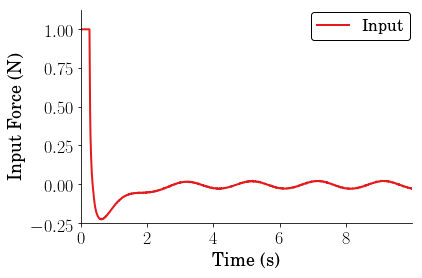

In [114]:
plot.generate_plot(time,
              np.vstack((mpc_input)),
              ['Input'],
              'Time (s)',
              r'Input Force (N)',
              filename='MPC-Input',
              folder='../../manuscript/Figures/Control-Analysis/MPC-Input/',
              num_col=1,legend_loc='best',ymax=0.1,ymin=0.01,save_plot=True,
              showplot=True)

In [117]:
x_mpc, y_mpc = get_xy_coords(n,mpc_response,lengths)
x_linear,y_linear = get_xy_coords(n,lin_response,lengths)

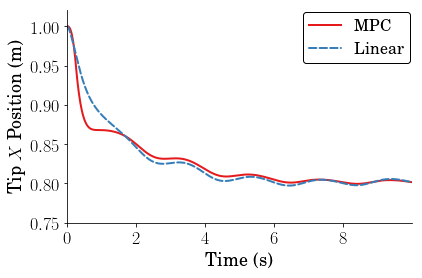

In [118]:
plot.generate_plot(time,
              np.vstack((x_mpc[:,-1],x_linear[:,-1])),
              ['MPC','Linear'],
              'Time (s)',
              r'Tip $X$ Position (m)',
              filename='Tip-X-Coord',
              folder='../../manuscript/Figures/Control-Analysis/MPC-vs-PD/',
              num_col=1,legend_loc='best',ymax=0.1,ymin=0.01,save_plot=True,
              showplot=True)

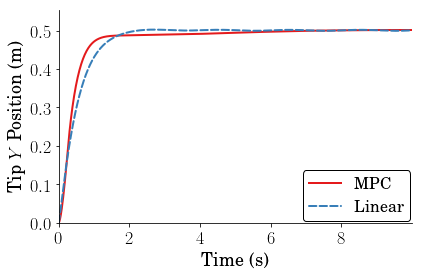

In [119]:
plot.generate_plot(time,
              np.vstack((y_mpc[:,-1],y_linear[:,-1])),
              ['MPC','Linear'],
              'Time (s)',
              r'Tip $Y$ Position (m)',
              filename='Tip-Y-Coord',
              folder='../../manuscript/Figures/Control-Analysis/MPC-vs-PD/',
              num_col=1,legend_loc='best',ymax=0.1,ymin=0.01,save_plot=True,
              showplot=True)

In [120]:
y_mpc_error = np.sqrt(np.square(y_desired - y_mpc[:,-1]))
y_lin_error = np.sqrt(np.square(y_desired - y_linear[:,-1]))

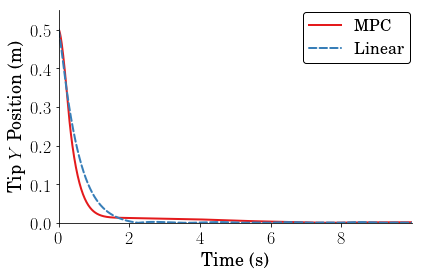

In [121]:
plot.generate_plot(time,
              np.vstack((y_mpc_error,y_lin_error)),
              ['MPC','PD'],
              'Time (s)',
              r'Tip $Y$ Position (m)',
              filename='Tip-Y-Erro',
              folder='../../manuscript/Figures/Control-Analysis/MPC-vs-PD/',
              num_col=1,legend_loc='best',ymax=0.1,ymin=0.01,save_plot=True,
              showplot=True)

In [ ]:
%%capture
fps = int(np.round(1 / dt))

FFMpegWriter = writers['ffmpeg']

def update_lines(num, x,y, lines):
    lines.set_data(x[num],y[num])
    return lines

# Attaching 3D axis to the figure
fig = plt.figure()
ax = plt.gca()

lines, = ax.plot([], [], 'o-', lw=2)

plt.axes().set_aspect('equal')
#data = np.array([x,y])

# Setting the axes properties
ax.set_xlim([-1, 1.0])
ax.set_xlabel('X (m)')

ax.set_ylim([-1, 1])
ax.set_ylabel('Y (m)')

In [122]:
# This cell will just improve the styling of the notebook
from IPython.core.display import HTML
from IPython.display import Image 
import urllib.request
response = urllib.request.urlopen("https://raw.githubusercontent.com/danielnewman09/Thesis-Notebooks/master/Styling/IpythonNotebook.css")
HTML(response.read().decode("utf-8"))